# 4 Autonomous Research Agents — LangGraph Agentic Graph

**Architecture:** A single LangGraph executor node routes dynamically at runtime.  
The flow is **never hard-coded** — each agent decides `next_agent` in its output.

| Agent | Role |
|-------|------|
| **Planner** | Understands goal, breaks into sub-questions, decides who runs next |
| **Researcher** | RAG retrieval from vector DB, grounded answers + sources |
| **Evaluator** | Scores confidence, detects gaps, routes to Expansion or END |
| **Expansion** | ArXiv search (online mode) **or** idea generation only (workspace mode) |

---

## Two Operating Modes

| Mode | `search_mode` value | Expansion behaviour |
|------|--------------------|--------------------|
| **Online** | `"online"` | Searches ArXiv, downloads & indexes new papers, loops back to Researcher |
| **Workspace-only** | `"workspace"` | Never touches the internet — uses only local PDFs already indexed |

Set `SEARCH_MODE` in **Section 11** before running.

---

```
  ┌─────────────────────────────────────────┐
  │          LangGraph StateGraph           │
  │                                         │
  │   ┌──────────────────────────────┐      │
  │   │       agent_executor         │◄─┐   │
  │   │  (single dynamic dispatcher) │  │   │
  │   └──────────┬───────────────────┘  │   │
  │              │                      │   │
  │         route(state)                │   │
  │         /         \                 │   │
  │      LOOP          END              │   │
  │        └───────────┘────────────────┘   │
  └─────────────────────────────────────────┘

  AGENT_REGISTRY maps name → function at runtime:
    'Planner'    → planner_agent(state)
    'Researcher' → researcher_agent(state)
    'Evaluator'  → evaluator_agent(state)
    'Expansion'  → expansion_agent(state)   ← behaviour controlled by search_mode
```

## 0. Install Dependencies

In [ ]:
# !pip install -q langgraph langchain langchain-core langchain-community langchain-groq \
#               langchain-huggingface langchain-chroma chromadb sentence-transformers \
#               pypdf arxiv python-dotenv

## 1. Imports & Environment

In [1]:
import os
import json
import hashlib
from pathlib import Path
from typing import Any, Callable, TypedDict

import arxiv
from dotenv import load_dotenv

from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

load_dotenv()

# ── LLM (Groq — swap for any LangChain ChatModel) ──────────────────────────
llm = None
try:
    from langchain_groq import ChatGroq
    _key = os.getenv("GROQ_API_KEY", "")
    if _key:
        llm = ChatGroq(
            model=os.getenv("GROQ_MODEL", "llama-3.3-70b-versatile"),
            temperature=0.1,
            api_key=_key,
        )
        print("✅ LLM ready:", llm.model_name)
    else:
        print("⚠️  GROQ_API_KEY not set — agents will use fallback logic")
except ImportError:
    print("⚠️  langchain-groq not installed — agents will use fallback logic")

# ── Workspace directories ───────────────────────────────────────────────────
WORK_DIR   = Path("./agent_workspace")
PDF_DIR    = WORK_DIR / "papers_local"       # drop your PDFs here
ARXIV_DIR  = WORK_DIR / "papers_arxiv"       # Expansion agent saves here
CHROMA_DIR = WORK_DIR / "chroma_db"

for d in [WORK_DIR, PDF_DIR, ARXIV_DIR, CHROMA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("📁 Workspace:", WORK_DIR.resolve())

d:\S\1602_24_733_186\Reasearch Hub\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ LLM ready: llama-3.3-70b-versatile
📁 Workspace: D:\S\1602_24_733_186\Reasearch Hub\agent_workspace


## 2. Shared Helpers

In [2]:
# ── JSON parsing ────────────────────────────────────────────────────────────
def _parse_json(text: str) -> dict:
    t = text.strip()
    if t.startswith("```"):
        t = t.replace("```json", "").replace("```", "").strip()
    return json.loads(t)


def _llm_json(prompt: str, fallback: dict) -> dict:
    """Call the LLM and parse JSON output. Return fallback on any error."""
    if llm is None:
        return fallback
    try:
        raw = llm.invoke([HumanMessage(content=prompt)]).content
        return _parse_json(raw)
    except Exception as e:
        print(f"  [LLM parse error] {e}")
        return fallback


# ── Vector DB (Chroma + HuggingFace embeddings) ─────────────────────────────
def build_vectordb():
    """Instantiate (or reuse) the persistent Chroma vector store."""
    try:
        from langchain_huggingface import HuggingFaceEmbeddings
    except ImportError:
        from langchain_community.embeddings import HuggingFaceEmbeddings  # type: ignore
    try:
        from langchain_chroma import Chroma
    except ImportError:
        from langchain_community.vectorstores import Chroma  # type: ignore

    emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vdb = Chroma(
        collection_name="autonomous_4agents",
        embedding_function=emb,
        persist_directory=str(CHROMA_DIR),
    )
    return vdb


def ingest_dirs(vdb, dirs: list[Path]) -> int:
    """Load all PDFs from dirs, chunk them, and upsert into the vector store."""
    pdfs = [p for d in dirs for p in d.rglob("*.pdf")]
    docs: list[Document] = []
    for p in pdfs:
        try:
            pages = PyPDFLoader(str(p)).load()
            for pg in pages:
                pg.metadata["source"] = str(p)
            docs.extend(pages)
        except Exception:
            pass
    if not docs:
        return 0
    splitter = RecursiveCharacterTextSplitter(chunk_size=1_200, chunk_overlap=200)
    chunks = splitter.split_documents(docs)
    ids = [
        hashlib.md5(
            f"{c.metadata.get('source')}|{c.metadata.get('page',-1)}|{c.page_content[:80]}"
            .encode()
        ).hexdigest()
        for c in chunks
    ]
    if chunks:
        vdb.add_documents(chunks, ids=ids)
    return len(chunks)


def retrieve(vdb, query: str, k: int = 8) -> list[Document]:
    return vdb.similarity_search(query, k=k)


# ── ArXiv helper ─────────────────────────────────────────────────────────────
def arxiv_expand(query: str, max_results: int = 4) -> list[Path]:
    """Search ArXiv, download PDFs, return file paths."""
    client = arxiv.Client(page_size=max_results, delay_seconds=3, num_retries=3)
    search = arxiv.Search(
        query=query, max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance,
    )
    saved = []
    for r in client.results(search):
        try:
            fp = r.download_pdf(dirpath=str(ARXIV_DIR), filename=f"{r.get_short_id()}.pdf")
            saved.append(Path(fp))
        except Exception:
            pass
    return saved


print("✅ Helpers ready")

✅ Helpers ready


## 3. State Schema

One `TypedDict` carries everything through the graph.  
`current_agent` tells the executor **which** agent to run next.

In [ ]:
class AgentState(TypedDict, total=False):
    # ── Core ──────────────────────────────────────────────────────────────
    goal: str                   # research question
    vdb: Any                    # Chroma vector store (passed by reference)
    current_agent: str          # which agent is active RIGHT NOW
    next_agent: str             # where to route after this agent
    iterations: int             # expansion loop counter
    max_iterations: int         # hard cap on expansion loops

    # ── Mode ──────────────────────────────────────────────────────────────
    search_mode: str            # "online"  → ArXiv search allowed
                                # "workspace" → use only local/already-indexed PDFs

    # ── Per-agent outputs (accumulated in state) ─────────────────────────
    planner:    dict            # {subtasks, next_agent}
    researcher: dict            # {answer, sources, next_agent}
    evaluator:  dict            # {confidence, missing_aspects, next_agent}
    expansion:  dict            # {query, papers_downloaded, chunks_added, saturated, ideas, mode}

    # ── Final outputs ────────────────────────────────────────────────────
    final_answer: str
    final_sources: list
    future_ideas: list
    trace: list                 # execution log ["Planner → Researcher", ...]

    # ── Insufficiency tracking ────────────────────────────────────────────
    insufficient_data: bool     # True when the system could not gather enough evidence
    insufficiency_reason: str   # human-readable explanation of why data was insufficient

## 4. Agent 1 — Planner (Lightweight Brain)

- Understands the research goal  
- Breaks it into sub-questions  
- Decides who runs next (always `Researcher`)  
- **Does NOT search** — pure reasoning only

In [4]:
def planner_agent(state: AgentState) -> dict:
    goal = state["goal"]
    print(f"  🧠 [Planner] Goal: {goal[:80]}...")

    fallback = {
        "subtasks": ["model architecture", "training datasets", "evaluation benchmarks"],
        "next_agent": "Researcher",
    }
    prompt = f"""You are the Planner Agent.
Research goal: {goal}

Your job:
1. Understand the goal deeply.
2. Break it into 3-5 focused sub-questions.
3. Do NOT search — only plan.
4. Always route next to Researcher.

Return ONLY valid JSON:
{{"subtasks": ["sub-question 1", "sub-question 2", "..."], "next_agent": "Researcher"}}"""

    out = _llm_json(prompt, fallback)
    subtasks = out.get("subtasks", fallback["subtasks"])
    if not isinstance(subtasks, list):
        subtasks = fallback["subtasks"]

    print(f"  🧠 [Planner] Subtasks: {subtasks}")
    return {
        "planner": {"subtasks": subtasks, "next_agent": "Researcher"},
        "next_agent": "Researcher",
    }

## 5. Agent 2 — Researcher (RAG Agent)

- Retrieves evidence from the Chroma vector DB  
- Generates a grounded answer with source citations  
- Routes to `Evaluator`

In [ ]:
def researcher_agent(state: AgentState) -> dict:
    goal     = state["goal"]
    vdb      = state["vdb"]
    subtasks = state.get("planner", {}).get("subtasks", [])
    mode     = state.get("search_mode", "online")
    print(f"  🔍 [Researcher] Retrieving for {len(subtasks)} subtasks...")

    # RAG retrieval
    query = f"Goal: {goal}\nSubtasks: {'; '.join(subtasks)}"
    docs  = retrieve(vdb, query, k=8)

    sources  = []
    evidence = []
    for d in docs:
        src  = d.metadata.get("source", "unknown")
        page = d.metadata.get("page", "?")
        sources.append({"source": src, "page": page})
        evidence.append(f"[{src} | page {page}]\n{d.page_content[:800]}")

    # ── No evidence in DB ─────────────────────────────────────────────────
    if not evidence:
        if mode == "online":
            reason = (
                "The vector DB is empty — no local or ArXiv papers have been indexed yet. "
                "The Expansion agent will search ArXiv."
            )
        else:
            reason = (
                "The vector DB is empty and workspace mode is active — "
                "no local PDFs were found. "
                f"Please add PDFs to: {PDF_DIR.resolve()} and re-run Section 10."
            )
        print(f"  🔍 [Researcher] ⚠️  No evidence — {reason}")
        return {
            "researcher":        {"answer": "", "sources": [], "next_agent": "Evaluator"},
            "final_answer":      "",
            "final_sources":     [],
            "insufficient_data": True,
            "insufficiency_reason": reason,
            "next_agent":        "Evaluator",
        }

    # ── Build grounded answer from evidence ───────────────────────────────
    fallback = {"answer": "Insufficient grounded evidence.", "next_agent": "Evaluator"}
    prompt = f"""You are the Researcher Agent (RAG).
Research goal: {goal}
Subtasks: {subtasks}

Retrieved evidence:
{chr(10).join(evidence[:6])}

Write a grounded, factual answer citing evidence above.
Return ONLY valid JSON:
{{"answer": "...", "next_agent": "Evaluator"}}"""
    out    = _llm_json(prompt, fallback)
    answer = str(out.get("answer", fallback["answer"]))

    print(f"  🔍 [Researcher] Sources found: {len(sources)}")
    return {
        "researcher":    {"answer": answer, "sources": sources, "next_agent": "Evaluator"},
        "final_answer":  answer,
        "final_sources": sources,
        "next_agent":    "Evaluator",
    }

## 6. Agent 3 — Evaluator (Critic + Analyzer)

- Judges whether the answer is sufficient  
- Scores confidence (0–1)  
- Detects missing aspects  
- **Online mode:** routes to `END` if confidence ≥ 0.75 **and** ≥ 4 sources, else `Expansion`  
- **Workspace mode:** routes to `END` once the vector DB has been exhausted (no new chunks possible), accepting a lower confidence threshold (≥ 0.50)

In [6]:
def evaluator_agent(state: AgentState) -> dict:
    goal        = state["goal"]
    answer      = state.get("researcher", {}).get("answer", "")
    sources     = state.get("researcher", {}).get("sources", [])
    mode        = state.get("search_mode", "online")
    print(f"  ⚖️  [Evaluator] Mode={mode} | Judging answer ({len(sources)} sources)...")

    fallback = {
        "confidence": 0.55 if len(sources) >= 3 else 0.30,
        "missing_aspects": ["experimental validation", "ablation studies"],
        "next_agent": "Expansion",
    }

    mode_instruction = (
        "If confidence >= 0.75 AND sources >= 4, set next_agent to END. "
        "Otherwise set next_agent to Expansion."
        if mode == "online"
        else
        "If confidence >= 0.50 OR sources >= 2, set next_agent to END. "
        "We are in workspace-only mode — no new papers can be fetched, "
        "so Expansion will only generate ideas, not improve retrieval. "
        "Be lenient: end unless the answer is clearly empty or completely off-topic."
    )

    prompt = f"""You are the Evaluator Agent.
Research goal: {goal}
Current answer: {answer[:1500]}
Number of sources: {len(sources)}
Operating mode: {mode}

Tasks:
1. Score confidence from 0.0 to 1.0 (how well the answer covers the goal).
2. List specific missing aspects (if any).
3. Routing rule — {mode_instruction}

Return ONLY valid JSON:
{{"confidence": 0.62, "missing_aspects": ["..."], "next_agent": "Expansion"}}"""

    out = _llm_json(prompt, fallback)

    confidence      = float(out.get("confidence", fallback["confidence"]))
    missing_aspects = out.get("missing_aspects", fallback["missing_aspects"])
    if not isinstance(missing_aspects, list):
        missing_aspects = fallback["missing_aspects"]

    # Hard sufficiency rule — differs by mode
    if mode == "workspace":
        # In workspace mode be lenient: end if we have any answer with sources,
        # or if confidence is reasonable. Expansion can only generate ideas anyway.
        sufficient = (confidence >= 0.50) or (len(sources) >= 2)
    else:
        sufficient = confidence >= 0.75 and len(sources) >= 4

    next_agent = "END" if sufficient else "Expansion"

    print(f"  ⚖️  [Evaluator] Confidence={confidence:.2f} | Sufficient={sufficient} | Next={next_agent}")
    return {
        "evaluator": {
            "confidence":      confidence,
            "missing_aspects": missing_aspects,
            "next_agent":      next_agent,
        },
        "next_agent": next_agent,
    }

## 7. Agent 4 — Expansion (Explorer + Innovator)

**Online mode (`search_mode = "online"`):**
- Searches ArXiv for papers covering missing aspects  
- Ingests new PDFs into the vector DB  
- If new papers found → loops back to `Researcher`  
- If saturated (no new papers **or** max iterations reached) → generates ideas → `END`

**Workspace-only mode (`search_mode = "workspace"`):**
- Skips all internet access  
- Goes straight to generating novel research ideas from missing aspects  
- Always routes to `END` (no new retrieval is possible)

In [ ]:
def expansion_agent(state: AgentState) -> dict:
    goal           = state["goal"]
    vdb            = state["vdb"]
    missing        = state.get("evaluator", {}).get("missing_aspects", [])
    iterations     = int(state.get("iterations", 0)) + 1
    max_iterations = int(state.get("max_iterations", 4))
    mode           = state.get("search_mode", "online")
    # Was the last Researcher call a total blank?
    prev_answer    = state.get("final_answer", "")
    prev_sources   = state.get("final_sources", [])

    print(f"  🚀 [Expansion] Mode={mode} | Iteration {iterations}/{max_iterations}")
    print(f"  🚀 [Expansion] Missing aspects: {missing}")

    # ── Shared: generate novel research ideas ─────────────────────────────
    def _generate_ideas(reason: str) -> list[str]:
        print(f"  🚀 [Expansion] Generating ideas ({reason})...")
        fallback_ideas = {
            "ideas": [
                "Design targeted experiments to address missing aspects.",
                "Create stronger benchmarks with edge-case coverage.",
                "Run ablation studies to isolate causal contributors.",
                "Apply iterative human-in-the-loop error analysis.",
                "Explore cross-domain transfer to validate generalisability.",
            ]
        }
        prompt = f"""You are the Expansion Agent.
Research goal: {goal}
Missing aspects: {missing}
Reason for idea generation: {reason}

Generate 4-6 concrete, novel research ideas or future directions
that could address the missing aspects.

Return ONLY valid JSON:
{{"ideas": ["idea 1", "idea 2", "..."]}}"""
        out = _llm_json(prompt, fallback_ideas)
        raw = out.get("ideas", fallback_ideas["ideas"])
        return [str(x) for x in raw] if isinstance(raw, list) else fallback_ideas["ideas"]

    # ══════════════════════════════════════════════════════════════════════
    # WORKSPACE-ONLY MODE — no internet, ideas only
    # ══════════════════════════════════════════════════════════════════════
    if mode == "workspace":
        ideas = _generate_ideas("workspace-only mode — no ArXiv access")

        # Detect true insufficiency: DB was empty when Researcher ran
        truly_insufficient = (len(prev_sources) == 0 and prev_answer == "")
        if truly_insufficient:
            insuff_reason = (
                "Workspace mode is active but the vector DB contains no documents. "
                f"Add PDFs to {PDF_DIR.resolve()} and re-run Section 10."
            )
            print(f"  🚀 [Expansion] ⚠️  INSUFFICIENT DATA — {insuff_reason}")
        else:
            insuff_reason = ""

        print(f"  🚀 [Expansion] [WORKSPACE] Generated {len(ideas)} ideas → END")
        out_dict = {
            "iterations": iterations,
            "expansion": {
                "mode":              "workspace",
                "query":             None,
                "papers_downloaded": 0,
                "chunks_added":      0,
                "saturated":         True,
                "ideas":             ideas,
                "next_agent":        "END",
            },
            "future_ideas": ideas,
            "next_agent":   "END",
        }
        if truly_insufficient:
            out_dict["insufficient_data"]     = True
            out_dict["insufficiency_reason"]  = insuff_reason
        return out_dict

    # ══════════════════════════════════════════════════════════════════════
    # ONLINE MODE — ArXiv search + ingest
    # ══════════════════════════════════════════════════════════════════════
    query      = f"{goal} {' '.join(missing[:3])}"
    downloaded = arxiv_expand(query, max_results=4)
    added      = ingest_dirs(vdb, [ARXIV_DIR]) if downloaded else 0
    print(f"  🚀 [Expansion] [ONLINE] Downloaded {len(downloaded)} papers | Indexed {added} chunks")

    saturated  = (added == 0) or (iterations >= max_iterations)
    ideas      = _generate_ideas("ArXiv saturated") if saturated else []
    next_agent = "END" if saturated else "Researcher"

    # Detect true insufficiency: saturated on iteration 1 with no prior answer
    truly_insufficient = (
        saturated
        and iterations == 1
        and len(downloaded) == 0
        and len(prev_sources) == 0
    )
    if truly_insufficient:
        insuff_reason = (
            f"ArXiv returned no papers for the query: '{query}'. "
            "The topic may be too niche, phrased unusually, or ArXiv may be unreachable. "
            "Try rephrasing the research goal, adding local PDFs, or checking your connection."
        )
        print(f"  🚀 [Expansion] ⚠️  INSUFFICIENT DATA — {insuff_reason}")
    else:
        insuff_reason = ""

    print(f"  🚀 [Expansion] [ONLINE] Saturated={saturated} | Next={next_agent}")
    out_dict = {
        "iterations": iterations,
        "expansion": {
            "mode":              "online",
            "query":             query,
            "papers_downloaded": len(downloaded),
            "chunks_added":      added,
            "saturated":         saturated,
            "ideas":             ideas,
            "next_agent":        next_agent,
        },
        "future_ideas": ideas,
        "next_agent":   next_agent,
    }
    if truly_insufficient:
        out_dict["insufficient_data"]    = True
        out_dict["insufficiency_reason"] = insuff_reason
    return out_dict

## 8. Dynamic Registry & Executor

**No hard-coded edges between agents.**  
A single `agent_executor` node reads `state['current_agent']`,  
looks up the function in `AGENT_REGISTRY`, and calls it.

In [8]:
# ── Registry: name → function ────────────────────────────────────────────────
AGENT_REGISTRY: dict[str, Callable[[AgentState], dict]] = {
    "Planner":    planner_agent,
    "Researcher": researcher_agent,
    "Evaluator":  evaluator_agent,
    "Expansion":  expansion_agent,
}


# ── Single dynamic executor node ─────────────────────────────────────────────
def agent_executor(state: AgentState) -> AgentState:
    """
    The ONLY node in the graph.
    Reads current_agent from state, dispatches to the right function,
    then updates state with the result.
    """
    current = state.get("current_agent", "Planner")
    fn      = AGENT_REGISTRY.get(current)

    if fn is None:
        print(f"  ❌ Unknown agent: {current}")
        return {
            **state,
            "next_agent":    "END",
            "current_agent": "END",
            "trace":         state.get("trace", []) + [f"{current} -> UNKNOWN -> END"],
        }

    # Run the agent
    update     = fn(state)
    next_agent = update.get("next_agent", "END")
    trace      = state.get("trace", []) + [f"{current} → {next_agent}"]

    return {
        **state,
        **update,
        "current_agent": next_agent,
        "trace":         trace,
    }


# ── Conditional routing function ─────────────────────────────────────────────
def route(state: AgentState) -> str:
    """
    After every agent_executor call:
      - next_agent == 'END'  → stop the graph
      - anything else        → loop back to agent_executor
    """
    return "END" if state.get("next_agent", "END") == "END" else "LOOP"


print("✅ Registry:", list(AGENT_REGISTRY.keys()))

✅ Registry: ['Planner', 'Researcher', 'Evaluator', 'Expansion']


## 9. Build the LangGraph

```
  START
    │
    ▼
 agent_executor  ◄──────────────┐
    │                           │
  route(state)                  │
   /      \                     │
 END      LOOP ─────────────────┘
```

Only **one node**, one **conditional edge** — routing is 100% data-driven.

✅ LangGraph compiled


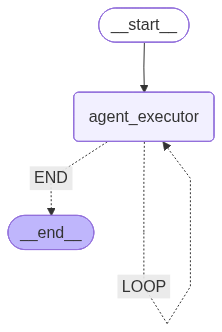

In [9]:
def build_graph():
    g = StateGraph(AgentState)

    # Single executor node
    g.add_node("agent_executor", agent_executor)

    # Entry point
    g.set_entry_point("agent_executor")

    # Dynamic routing — no hard-coded agent-to-agent edges
    g.add_conditional_edges(
        "agent_executor",
        route,
        {
            "LOOP": "agent_executor",   # run next agent in same node
            "END":  END,                # terminate graph
        },
    )

    return g.compile()


graph = build_graph()
print("✅ LangGraph compiled")

# Optional: visualise the graph structure
try:
    from IPython.display import display, Image
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("  (graph visualisation requires pygraphviz — skipping)")

## 10. Initialise Vector DB & Ingest Local Papers

In [10]:
print("Building vector DB...")
vdb = build_vectordb()

# Ingest any PDFs already in the workspace
chunks = ingest_dirs(vdb, [PDF_DIR, ARXIV_DIR])
print(f"✅ Vector DB ready | {chunks} chunks indexed from existing PDFs")
print(f"   Drop additional PDFs into: {PDF_DIR.resolve()}")

Building vector DB...


C:\Users\vamshisaikrishnaa\AppData\Local\Temp\ipykernel_20772\4140445745.py:33: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 316.93it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
C:\Users\vamshisaikrish

✅ Vector DB ready | 892 chunks indexed from existing PDFs
   Drop additional PDFs into: D:\S\1602_24_733_186\Reasearch Hub\agent_workspace\papers_local


## 11. Run the Autonomous Agent System

**Choose your mode then run the cell below.**

| `SEARCH_MODE` | What happens |
|---------------|-------------|
| `"online"` | Planner → Researcher (local RAG) → Evaluator → **Expansion downloads ArXiv papers** → loops until confident → ideas |
| `"workspace"` | Planner → Researcher (local RAG only) → Evaluator → **Expansion generates ideas from existing knowledge** → END |

> **Tip — workspace mode:** Make sure you have PDFs in `./agent_workspace/papers_local/`  
> and have run **Section 10** so they are indexed before starting.

In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║                    CONFIGURE HERE                           ║
# ╠══════════════════════════════════════════════════════════════╣
# ║  SEARCH_MODE                                                ║
# ║    "online"    — search ArXiv for missing papers            ║
# ║    "workspace" — use only locally indexed PDFs              ║
# ╚══════════════════════════════════════════════════════════════╝

SEARCH_MODE    = "online"       # ← change to "workspace" for offline mode

RESEARCH_GOAL  = (
    "What are the key limitations of large language models in "
    "long-context reasoning and how can retrieval-augmented generation overcome them?"
)

MAX_ITERATIONS = 3              # max Expansion→Researcher loops (online mode only)

# ── Validate mode ─────────────────────────────────────────────────────────
assert SEARCH_MODE in ("online", "workspace"), \
    f"SEARCH_MODE must be 'online' or 'workspace', got: {SEARCH_MODE!r}"

mode_label = {
    "online":    "🌐 ONLINE  — ArXiv search enabled",
    "workspace": "💾 WORKSPACE — local PDFs only, no internet",
}[SEARCH_MODE]

# ── Initial state ──────────────────────────────────────────────────────────
initial_state: AgentState = {
    "goal":           RESEARCH_GOAL,
    "vdb":            vdb,
    "search_mode":    SEARCH_MODE,
    "current_agent":  "Planner",
    "next_agent":     "Planner",
    "iterations":     0,
    "max_iterations": MAX_ITERATIONS,
    "future_ideas":   [],
    "trace":          [],
}

print("=" * 65)
print(f"MODE  : {mode_label}")
print(f"GOAL  : {RESEARCH_GOAL}")
print("=" * 65)

# ── Execute ────────────────────────────────────────────────────────────────
result = graph.invoke(initial_state)

print("\n" + "=" * 65)
print("RUN COMPLETE")
print("=" * 65)

## 12. Results

In [ ]:
ex   = result.get("expansion", {})
mode = result.get("search_mode", "online")

# ── Header ────────────────────────────────────────────────────────────────
print("=" * 65)
print(f"MODE : {'🌐 ONLINE' if mode == 'online' else '💾 WORKSPACE'}")
print("=" * 65)

# ── Insufficient data warning — shown first if triggered ─────────────────
if result.get("insufficient_data"):
    reason = result.get("insufficiency_reason", "Unknown reason.")
    print("\n" + "⚠️ " * 20)
    print("  INSUFFICIENT DATA — the system could not gather enough evidence")
    print("  Reason  :", reason)
    print()
    if mode == "online":
        print("  Suggestions:")
        print("    1. Rephrase RESEARCH_GOAL with more specific or standard terminology")
        print("    2. Add relevant PDFs manually to ./agent_workspace/papers_local/")
        print("       then re-run Section 10 to index them")
        print("    3. Increase max_results in expansion_agent (currently 4)")
        print("    4. Check your internet connection (ArXiv requires network access)")
    else:
        print("  Suggestions:")
        print("    1. Add PDFs to ./agent_workspace/papers_local/ and re-run Section 10")
        print("    2. Switch to SEARCH_MODE = 'online' to let the agent fetch papers")
    print("⚠️ " * 20)

# ── Execution trace ───────────────────────────────────────────────────────
print("\nEXECUTION TRACE")
print("-" * 40)
for step in result.get("trace", []):
    print(" •", step)

# ── Planner output ────────────────────────────────────────────────────────
print("\nPLANNER — SUB-QUESTIONS")
print("-" * 40)
for i, t in enumerate(result.get("planner", {}).get("subtasks", []), 1):
    print(f"  {i}. {t}")

# ── Researcher output ─────────────────────────────────────────────────────
print("\nRESEARCHER — GROUNDED ANSWER")
print("-" * 40)
answer = result.get("final_answer", "")
if answer:
    print(answer)
else:
    print("  ⚠️  No answer produced — evidence was unavailable.")

print("\nRESEARCHER — SOURCES")
sources = result.get("final_sources", [])
if sources:
    for s in sources[:10]:
        print(f"  [p.{s.get('page', '?')}] {s.get('source', 'unknown')}")
else:
    print("  ⚠️  No sources retrieved.")

# ── Evaluator output ──────────────────────────────────────────────────────
ev = result.get("evaluator", {})
if ev:
    print("\nEVALUATOR")
    print("-" * 40)
    conf = ev.get("confidence", None)
    print(f"  Confidence  : {conf if conf is not None else 'N/A'}")
    print(f"  Missing     : {ev.get('missing_aspects', [])}")

# ── Expansion output ──────────────────────────────────────────────────────
if ex:
    print("\nEXPANSION")
    print("-" * 40)
    print(f"  Mode             : {ex.get('mode', mode)}")
    if ex.get("mode") == "online":
        print(f"  ArXiv query      : {ex.get('query', 'N/A')}")
        print(f"  Papers downloaded: {ex.get('papers_downloaded', 0)}")
        print(f"  Chunks indexed   : {ex.get('chunks_added', 0)}")
    else:
        print("  (no internet access — workspace mode)")
    print(f"  Saturated        : {ex.get('saturated', True)}")

# ── Future ideas ──────────────────────────────────────────────────────────
ideas = result.get("future_ideas", [])
label = (
    "FUTURE RESEARCH IDEAS  ⚠️  (generated from LLM knowledge — no paper evidence)"
    if result.get("insufficient_data") else
    "FUTURE RESEARCH IDEAS"
)
if ideas:
    print(f"\n{label}")
    print("-" * 40)
    for i, idea in enumerate(ideas, 1):
        print(f"  {i}. {idea}")

## 13. How to Customise

| What | Where |
|------|-------|
| **Switch mode** | Set `SEARCH_MODE = "online"` or `"workspace"` in **Section 11** |
| Change research goal | `RESEARCH_GOAL` in **Section 11** |
| Add local PDFs | Drop files into `./agent_workspace/papers_local/` and re-run **Section 10** |
| Swap LLM | Replace `ChatGroq` in **Section 1** with any LangChain `BaseChatModel` |
| Add a 5th agent | Define `my_agent(state)`, add to `AGENT_REGISTRY`, any agent can set `next_agent = 'MyAgent'` |
| Change online sufficiency | Edit `sufficient = confidence >= 0.75 and len(sources) >= 4` in `evaluator_agent` |
| Change workspace sufficiency | Edit `sufficient = (confidence >= 0.50) or (len(sources) >= 2)` in `evaluator_agent` |
| More ArXiv papers | Increase `max_results` in `expansion_agent` |

---

### Mode comparison

```
ONLINE mode flow:
  Planner → Researcher(RAG) → Evaluator
                                  │
                          confident? ──YES──► END
                                  │
                                  NO
                                  │
                            Expansion(ArXiv download)
                                  │
                           new papers? ──YES──► Researcher (loop)
                                  │
                                  NO (saturated)
                                  │
                            generate ideas → END

WORKSPACE mode flow:
  Planner → Researcher(RAG) → Evaluator
                                  │
                      any answer? ──YES──► END
                                  │
                                  NO (empty DB)
                                  │
                          Expansion(ideas only) → END
```

### Why the flow is not hard-coded

```python
# ❌  Hard-coded (bad):  Planner → Researcher → Evaluator → Expansion
g.add_edge("planner",    "researcher")
g.add_edge("researcher", "evaluator")
g.add_edge("evaluator",  "expansion")

# ✅  Dynamic (this notebook): ONE node, data-driven routing
g.add_conditional_edges("agent_executor", route, {"LOOP": "agent_executor", "END": END})
# Each agent sets state['next_agent'] → routing happens at runtime
# Mode behaviour is embedded in the agent functions, not in graph edges
```